![SUTD](data/sutd.png)
# 50.040 Natural Language Processing (Summer 2020) Homework 1

### **Due 5 June 2020, 5pm** 



### STUDENT ID: 1002837

### Name: Andre Hadianto Lesmana

### Students with whom you have discussed (if any):

In [6]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from gensim.models import Word2Vec

# Introduction
Word embeddings are dense vectors that represent words, and capable of capturing semantic and syntactic similarity, relation with other words, etc.
We have introduced two approaches in the class to learn word embeddings: **Count-based** and **Prediction-based**. 
Here we will explore both approaches and learn *co-occurence matrices* word embeddings and *Word2Vec* word embeddings. Note that we use "word embeddings" and "word vectors" interchangeably.

-------

Before we start, you need to [download](http://mattmahoney.net/dc/text8.zip) the text8 dataset. Unzip the file and then put it under the "data" folder. The text8 dataset consists of one single line of long text. Please do not change the data unless you are requested to do so.

Environment:
- Python 3.5 or above
- gensim 
- sklearn
- numpy 

# 1. Count-based word embeddings

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "learn and live"

Document 2: "learn not and know not"

|     *    | and | know | learn | live | not |
|----------|-----|------|-------|------|-----|
| and      | 0   | 1    | 1     | 1    | 1   |
| know     | 1   | 0    | 0     | 0    | 1   |
| learn    | 1   | 0    | 0     | 0    | 1   |
| live     | 1   | 0    | 0     | 0    | 0   |
| not      | 1   | 1    | 1     | 0    | 0   |


The rows or columns can be used as word vectors but they are usually too large (linear in the size of the vocabulary). Thus 
in the next step we need to run "dimensionality reduction" algorithms like PCA, SVD.

### Construct co-occurence matrix

Before you start, please make sure you have downloaded the dataset "text8" in the introduction.

In [7]:
def read_corpus(file_path, size=500000):
    '''
    params:
        file_path --- str: path to your data file.
        size --- int or str: the size of the corpus
    return:
        corpus --- list[str]: list of word strings.
    '''
    with open(file_path, 'r') as f:
        text = f.read()
        if size=='all':
            corpus = text.split()
        else:
            corpus = text.split()[:size]
        return corpus

Let's have a look at the corpus

In [8]:
corpus = read_corpus(r'./data/text8')
print(corpus[0:100])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


### Question 1 [code]:
Implement the function "distinct_words" that reads in "corpus" and returns distinct words that appeared in the corpus, the number of distinct words. 

Then, run the sanity check cell below to check your implementation.

In [9]:
def distinct_words(corpus):
    """ 
    Determine a list of distinct words for the corpus.
    Params:
        corpus --- list[str]: list of words in the corpus
    Return:
        corpus_words --- list[str]: list of distinct words in the corpus; sort this list with built-in python function "sorted"
        num_corpus_words --- int: number of distinct in the corpus
    """

    ### You may need to use "set()" to remove duplicate words.
    ### YOUR CODE HERE (~2 lines)
    corpus_words = sorted(list(set(corpus)))
    num_corpus_words = len(corpus_words)
    ### END OF YOUR CODE

    return corpus_words, num_corpus_words

In [10]:
# --------------------------------------------------
# Run this sanity check to check your implementation
# --------------------------------------------------

# Define toy corpus
test_corpus = "learn and live".split() + "learn not and know not".split()
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(['learn','and','live','not','know'])))
ans_num_corpus_words = len(ans_test_corpus_words)

assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 2 [code]: 
Implement "compute_co_occurrence_matrix" that reads in "corpus" and "window_size", and returns a co-occurence matrix and a word-to-index dictionary.

Then, run the sanity check cell to check your implementation

In [11]:
def compute_co_occurrence_matrix(corpus, window_size=1):
    """ 
    Compute co-occurrence matrix for the given corpus and window_size (default of 1).
    
    Params:
        corpus --- list[str]: list of words
        window_size --- int: size of context window
    Return:
        M --- numpy array of shape (num_words, num_words)): 
              Co-occurence matrix of word counts. 
              The ordering of the words in the rows/columns should be the same as the ordering of the words 
              given by the distinct_words function.
              
        word2Ind --- dict: dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = np.zeros((num_words, num_words))
    word2Ind = {}
    
    ###    Each word in a document should be at the center of a window. Words near edges will have a smaller
    ###    number of co-occurring words.
    ###    For example, if we take the sentence "learn and live" with window size of 2,
    ###    "learn" will co-occur with "and", "live". 
    ###
    ### YOUR CODE HERE
    index = 0
    for word in words:
        if word not in word2Ind:
            word2Ind[word] = index
            index += 1
    for i in range(len(corpus)):
        for j in range(1, window_size+1):
            if i - j >= 0:
                M[word2Ind[corpus[i]]][word2Ind[corpus[i-j]]] += 1
            if i + j < len(corpus):
                M[word2Ind[corpus[i]]][word2Ind[corpus[i+j]]] += 1
            
    ### END OF YOUR CODE   
    return M, word2Ind

In [12]:
# ---------------------
# Run this sanity check
# ---------------------

# Define toy corpus and get co-occurrence matrix
test_corpus = "learn not and know not".split()
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 1., 0., 1.],
     [1., 0., 0., 1.],
     [0., 0., 0., 1.],
     [1., 1., 1., 0.]])

word2Ind_ans = {'and':0, 'know':1, 'learn':2,  'not':3}

# check correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# check correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 3 [code]:
Implement "pca" function below with python package sklearn.decomposition.PCA. For the use of PCA function, please refer to https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Then, run the sanity check cell to check your implementation

In [13]:
def pca(X, k=2):
    '''
    A wrapper of the sklearn.decomposition.PCA function.
    params:
        X --- numpy array of shape (num_words, word_embedding_size)
        k --- int: the number of principal components that we keep
    return:
        X_pca --- numpy array of shape (num_words, k)
    '''    
    ### YOUR CODE HERE (~2 line)
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X)
    ### END OF YOUR CODE
    return X_pca

In [14]:
# ---------------------
# Run this sanity check
# only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = "learn not and know not".split()
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = pca(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 4), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 4)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 4 [code]:
Implement "plot_embeddings" function to visualize the word embeddings on a 2-D plane. 

In [15]:
def plot_embeddings(X_pca, word2Ind, words):
    """ 
    Plot in a scatterplot the embeddings of the words specified in the list "words".
        
    params:
        X_pca --- numpy array of shape (num_words , 2): numpy array of 2-d word embeddings
        word2Ind --- dict: dictionary that maps words to indices
        words --- list[str]: a list of words of which the embeddings we want to visualize
    return:
        None
    """
    ### You may need to use "plt.scatter", "plt.text" and a for loop here
    ### YOUR CODE HERE (~ 7 lines)
    for word in words:
        x,y = X_pca[word2Ind[word]]
        plt.scatter(x, y, marker='x')
        plt.text(x, y, word)
    ### END OF YOUR CODE

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


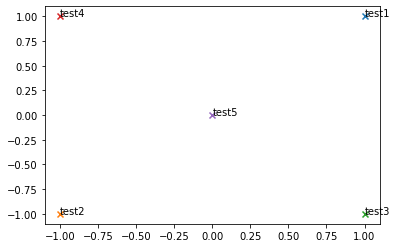

In [16]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

X_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(X_test, word2Ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="data/test_plot.png" width=40% style="float: left;"> </img>

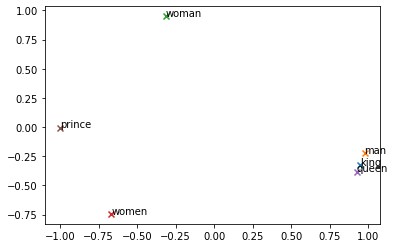

In [17]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
corpus = read_corpus(r'./data/text8',100000)
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(corpus, window_size=4)
M_reduced_co_occurrence = pca(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['king','man','woman','women','queen','prince']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

# 2. Prediction-based word embeddings

### Question 5 [written]:
Given a sentence "I am interested in NLP", what will be the context and target pairs in a CBOW/Skip-gram model if the window size is 1? Write your answer in the cell below

### I
Context:
- am


### am
Context:
- I
- interested


### interested
Context:
- am
- in


### in
Context:
- interested
- NLP


### NLP
Context:
- in

### Question 6 [code]:
Complete the code in the function *create_word_batch*, which can be used to divide a single sequence of words into batches of words. 

For example, the word sequence ["I", "like", "NLP", "So", "does", "he"] can be divided into two batches, ["I", "like", "NLP"], ["So", "does", "he"], each with batch_size=3 words. It is more efficient to train word embedding on batches of word sequences rather than on a long single sequence. 

Then, run the sanity check cell to check your implementation

In [31]:
def create_word_batch(words, batch_size=100):
    '''
    Split the words into batches
    params:
        words --- list[str]: a list of words
        batch_size --- int: the number of words in a batch
    return:
        batch_words: list[list[str]]batches of words, list
    '''
    batch_words = []
    
    ### YOUR CODE HERE
    batch = []
    for i, word in enumerate(words):
        if i % batch_size == 0 and i != 0:
            batch_words.append(batch)
            batch = []
        batch.append(word)
        if i == len(words)-1:
            batch_words.append(batch)
    ### END OF YOUR CODE
    return batch_words

In [33]:
# --------------------------------------------------
# Run this sanity check to check your implementation
# --------------------------------------------------
words_test = ["I", "like", "NLP", "So", "does", "he"]
batch_size_test = 3

ans = [["I", "like", "NLP"],["So", "does", "he"]]

batch_words_test = create_word_batch(words_test,batch_size_test)

assert ans == batch_words_test, 'your output does not match "ans"'
print('passed!')

passed!


### Question 7 [code]:
Use "Word2Vec" function to build a word2vec model. For the use of "Word2Vec" function, please ,refer to https://radimrehurek.com/gensim/models/word2vec.html. Please use the parameters we have set for you.

It may take a few minutes to train the model.

If you encounter "UserWarning: C extension not loaded, training will be slow", try to uninstall gensim first and then run "pip install gensim==3.6.0"

In [34]:
whole_corpus = corpus = read_corpus(r'./data/text8', 'all')
batch_words = create_word_batch(whole_corpus)

size = 100
min_count = 2
window = 3
sg = 1
### YOUR CODE HERE (1 line)
model = Word2Vec(batch_words, size=size, min_count=min_count, window=window, sg=sg)
### END OF YOUR CODE

### Question 8 [code]:
Implement "get_word2Ind" function below.

Then, run the sanity check cell to check your implementation.

In [35]:
def get_word2Ind(index2word):
    '''
    construct a dictionary that maps words to its index
    
    params:
        index2word --- list[str]: list of words
    return 
        word2index --- dict: keys are words, values are the corresponding indices
    '''
    word2index = dict()
    ### YOUR CODE HERE
    index = 0
    for word in index2word:
        if word not in word2index:
            word2index[word] = index
            index += 1
    ### END OF YOUR CODE
    return word2index

In [36]:
# --------------------------------------------------
# Run this sanity check to check your implementation
# --------------------------------------------------
i2w_test = ['I','love','it']
ans_test = get_word2Ind(i2w_test)

ans = {'I':0, 'love':1, 'it':2}
assert ans == ans_test, 'your output did not match the correct answer.'
print('passed!')

passed!


Run the cell below to visualize the word embeddings of the first 300 words in the vocabulary

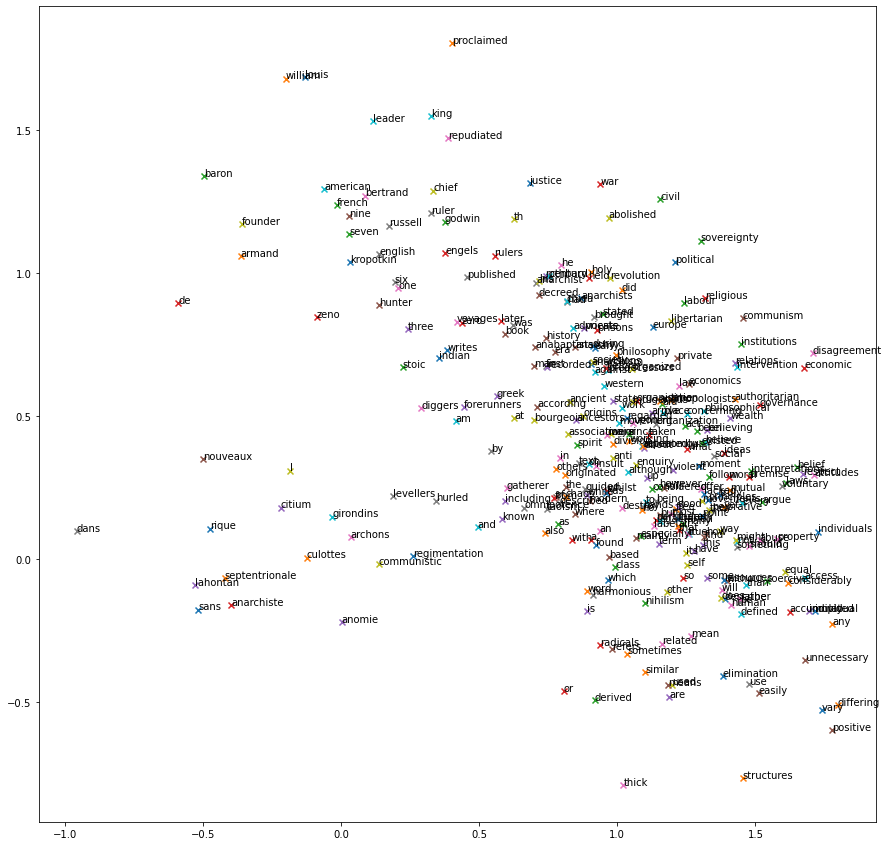

In [37]:
word2Ind = get_word2Ind(model.wv.index2word)

vocab = model.wv.vocab
words_to_visualize = list(vocab.keys())[:300]

vec_pca = pca(model.wv.vectors, 2)

plt.figure(figsize=(15,15))
plot_embeddings(vec_pca, word2Ind, words_to_visualize)

### Question 9:
Find the most similar words for the given words "dog","car","man". You need to use "model.wv.most_similar" function.

In [41]:
words =  ['dog', 'car', 'man'] 

### YOUR CODE HERE (~ 2 lines)
model.wv.most_similar(positive=words)
### END OF YOUR CODE

[('girl', 0.7698171138763428),
 ('pony', 0.7537394762039185),
 ('cub', 0.7468045949935913),
 ('puppy', 0.7435536980628967),
 ('pig', 0.7372956275939941),
 ('kitten', 0.7357900142669678),
 ('stranger', 0.7309681177139282),
 ('totoro', 0.7291594743728638),
 ('blackbeard', 0.7287378311157227),
 ('poodle', 0.7270768880844116)]

### Question 10 [written]:
Run the code below and explain the results in the empty cell.

From the documentation, `most_similar` method finds the top-N most similar docvecs from the training set. Positive docvecs contribute positively towards the similarity, negative docvecs contribute negatively. The method computes cosine similarity between a simple mean of the projection weight vectors of the given docs.  

'london' and 'japan' contributes positively while 'england' contributes negatively.   

The most similar word is 'tokyo', which is the capital of Japan. This must have been contributed from the fact that 'london' is a city and is the capital of England and 'japan' is a country. although 'england' is also a country, it subtracts the capital out of the context, but not completely. This results in 'tokyo' to come first.  

The rest of the results are mostly a mixture of capital cities and countries with the exception of 'nhk' which is a TV station in Japan. 'hong' and 'kong' are separated due to the spacing, causing 'kong' to be much less irrelevant 

In [39]:
model.wv.most_similar(positive=['london', 'japan'], negative=['england'])

[('tokyo', 0.7407660484313965),
 ('beijing', 0.6728848218917847),
 ('china', 0.6527534127235413),
 ('hong', 0.6398192644119263),
 ('mumbai', 0.6395539045333862),
 ('guangzhou', 0.6282325983047485),
 ('singapore', 0.6106400489807129),
 ('nhk', 0.6103701591491699),
 ('moscow', 0.5958348512649536),
 ('kong', 0.5945740938186646)]